In [1]:
from nnodely import *
from nnodely.support import earlystopping
import matplotlib.pyplot as plt
import os
import numpy as np

workspace = os.path.join(os.getcwd(), "saved_models")
inverted_pendulum = Modely(workspace=workspace)

def init_random_range(indexes, params_size, dict_param={'min_value': 0.0, 'max_value': 1.0}):
    import numpy as np
    min_val = dict_param.get('min_value', 0.0)
    max_val = dict_param.get('max_value', 1.0)
    return np.random.uniform(low=min_val, high=max_val)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.2 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [2]:
# Create neural model
model_name = 'learned_fir_filter_model'
pos                = Input('Xpos')
Ypos                = Input('Ypos')
Xvelocity           = Input('Xvelocity')
Xangular_velocity   = Input('Xangular_velocity')
Yvelocity           = Input('Yvelocity')
angle               = Input('Xangle')
Yangle              = Input('Yangle')
Yangular_velocity   = Input('Yangular_velocity')
F                   = Input('action')

noise1          = Input('noise1')
noise2          = Input('noise2')
noise3          = Input('noise3')
noise4          = Input('noise4')
noise5          = Input('noise5')
sigma_x         = Constant('sigma_x', values=0.0)
sigma_v         = Constant('sigma_v', values=0.0)
sigma_theta     = Constant('sigma_theta', values=0.0)
sigma_omega     = Constant('sigma_omega', values=0.0)
sigma_force     = Constant('sigma_force', values=0.0)
sw = 10
g               = Constant('g', values=9.81)
dt              = Constant('dt', values=0.02)
gear            = Constant('gear', values=100)
init_value = 0.5
tv1             = Parameter('tv1', sw=sw, values=[[0.0]]*(sw-1) + [[1.0]])
tv2             = Parameter('tv2', sw=sw, values=[[0.0]]*(sw-1) + [[1.0]])
tv3             = Parameter('tv3', sw=sw, values=[[0.0]]*(sw-1) + [[1.0]])
tv4             = Parameter('tv4', sw=sw, values=[[0.0]]*(sw-1) + [[1.0]])
tv5             = Parameter('tv5', sw=sw, values=[[0.0]]*(sw-1) + [[1.0]])
init_value = 3.0
m1              = Parameter('m1', init=init_random_range, init_params={'min_value':0, 'max_value':init_value})
m2              = Parameter('m2', init=init_random_range, init_params={'min_value':0, 'max_value':init_value})
l               = Parameter('l', init=init_random_range, init_params={'min_value':0, 'max_value':init_value})
b               = Parameter('b', init=init_random_range, init_params={'min_value':0, 'max_value':init_value})
d               = Parameter('d', init=init_random_range, init_params={'min_value':0, 'max_value':init_value})
I               = Parameter('I', init=init_random_range, init_params={'min_value':0, 'max_value':init_value})

def inv_pend(p, v, alpha, omega, u):
    # Equations of motion for the inverted pendulum on a cart
    sin_theta = Sin(alpha)
    cos_theta = Cos(alpha)
    I_eff = I + m2 * l**2
    denom = (m1+m2)*I_eff - (m2*l*cos_theta)**2

    # Input force
    F = gear * u
    
    # Friction
    friction_cart = I_eff * b*v 
    friction_pend = (m1+m2) * d*omega 

    # Angular acceleration (omega_dot)
    omega_dot = (- m2**2*l**2*omega**2*sin_theta*cos_theta
                 - friction_pend
                 + (m1+m2)*m2*g*l*sin_theta
                 + m2*l*b*v*cos_theta
                 - m2*l*cos_theta*F
    )/ denom

    # Linear acceleration of the cart (v_dot)
    v_dot = (I_eff*m2*l*omega**2*sin_theta
             - friction_cart
             - m2**2*l**2*g*sin_theta*cos_theta
             + m2*l*d*omega*cos_theta
             + F*I_eff
    )/ denom

    p_dot = v
    alpha_dot = omega

    return [p_dot, v_dot, alpha_dot, omega_dot]

# Adding noise to the inputs
x_noisy = Fir(W=tv1)(pos.sw(sw) + noise2.sw(sw)*sigma_x)
vel_noisy = Fir(W=tv2)(Xvelocity.sw(sw) + noise1.sw(sw)*sigma_v)
ang_vel_noisy = Fir(W=tv3)(Xangular_velocity.sw(sw) + noise3.sw(sw) * sigma_omega)
theta_noisy = Fir(W=tv4)(angle.sw(sw) + noise4.sw(sw) * sigma_theta)
F_noisy = Fir(W=tv5)(F.sw(sw) + noise5.sw(sw) * sigma_force)

# Runge-Kutta 4th order method
k1 = inv_pend(x_noisy, vel_noisy, theta_noisy, ang_vel_noisy, F_noisy)
k2 = inv_pend(x_noisy + k1[0]*dt/2, vel_noisy + k1[1]*dt/2, theta_noisy + k1[2]*dt/2, ang_vel_noisy + k1[3]*dt/2, F_noisy)
k3 = inv_pend(x_noisy + k2[0]*dt/2, vel_noisy + k2[1]*dt/2, theta_noisy + k2[2]*dt/2, ang_vel_noisy + k2[3]*dt/2, F_noisy)
k4 = inv_pend(x_noisy + k3[0]*dt, vel_noisy + k3[1]*dt, theta_noisy + k3[2]*dt, ang_vel_noisy + k3[3]*dt, F_noisy)

# Update state variables
dt_xdot = (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])*dt/6
xdot = vel_noisy + dt_xdot
xdot.closedLoop(Xvelocity)

dt_x = (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])*dt/6
x = x_noisy + dt_x
x.closedLoop(pos)

dt_thetadot = (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])*dt/6
thetadot = ang_vel_noisy + dt_thetadot
thetadot.closedLoop(Xangular_velocity)

dt_theta = (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])*dt/6
theta = theta_noisy + dt_theta
theta.closedLoop(angle)

# Remove noise on states in closed-loop predictions
zero = pos.last() * 0.0
noise1.closedLoop(zero)
noise2.closedLoop(zero)
noise3.closedLoop(zero)
noise4.closedLoop(zero)

# Output and loss
est_theta = Output('est_theta', theta)
est_thetadot = Output('est_thetadot', thetadot)
est_xdot = Output('est_xdot', xdot)
est_x = Output('est_x', x)

inverted_pendulum.addModel('pendulum', [est_thetadot, est_theta, est_xdot, est_x])
inverted_pendulum.addMinimize('ang_vel_error', Yangular_velocity.last(), thetadot, loss_function='mse')
inverted_pendulum.addMinimize('angle_error', Yangle.last(), theta, loss_function='mse')
inverted_pendulum.addMinimize('vel_error', Yvelocity.last(), xdot, loss_function='mse')
inverted_pendulum.addMinimize('pos_error', Ypos.last(), x, loss_function='mse')
inverted_pendulum.neuralizeModel(sample_time = 0.02)

[neuralizeModel] Closed loop on Xpos with sample in the future.
[neuralizeModel] Closed loop on Xangle with sample in the future.
[neuralizeModel] Closed loop on Xvelocity with sample in the future.
[neuralizeModel] Closed loop on Xangular_velocity with sample in the future.
================================ nnodely Model =================================
{'Constants': {'Constant39': {'dim': 1, 'values': [2.0]},
               'Constant40': {'dim': 1, 'values': [2.0]},
               'Constant41': {'dim': 1, 'values': [2.0]},
               'Constant42': {'dim': 1, 'values': [2.0]},
               'Constant43': {'dim': 1, 'values': [2.0]},
               'Constant44': {'dim': 1, 'values': [2.0]},
               'Constant45': {'dim': 1, 'values': [2.0]},
               'Constant46': {'dim': 1, 'values': [2.0]},
               'Constant48': {'dim': 1, 'values': [2.0]},
               'Constant49': {'dim': 1, 'values': [2.0]},
               'Constant50': {'dim': 1, 'values': [2.0]},
     

In [3]:
# Data loading
import torch
torch.set_num_threads(4)
data_struct = ['time', 'action', 'Xpos', 'Xangle', 'Xvelocity', 'Xangular_velocity', 'Ypos', 'Yangle', 'Yvelocity', 'Yangular_velocity', 'noise1', 'noise2', 'noise3', 'noise4', 'noise5', 'acc', 'ang_acc']
data_folder = os.path.join(os.path.abspath(''), 'data')
inverted_pendulum.loadData(name='data', source=data_folder, format=data_struct, delimiter=',', header=0)
data_folder = os.path.join(os.path.abspath(''), 'data_val')
inverted_pendulum.loadData(name='data_val', source=data_folder, format=data_struct, delimiter=',', header=0)
data_folder = os.path.join(os.path.abspath(''),'data_test')
inverted_pendulum.loadData(name='data_test', source=data_folder, format=data_struct, delimiter=',', header=0)

============================ nnodely Model Dataset =============================
Dataset Name:                 data
Number of files:              150
Total number of samples:      21150
Shape of Xpos:                (21150, 10, 1)
Shape of noise4:              (21150, 10, 1)
Shape of Xangle:              (21150, 10, 1)
Shape of noise5:              (21150, 10, 1)
Shape of action:              (21150, 10, 1)
Shape of noise1:              (21150, 10, 1)
Shape of Xvelocity:           (21150, 10, 1)
Shape of noise3:              (21150, 10, 1)
Shape of Xangular_velocity:   (21150, 10, 1)
Shape of noise2:              (21150, 10, 1)
Shape of Ypos:                (21150, 1, 1)
Shape of Yvelocity:           (21150, 1, 1)
Shape of Yangle:              (21150, 1, 1)
Shape of Yangular_velocity:   (21150, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 data_val
Number of files:              100
Total number of samples:      1410

In [4]:
# Training
prediction_samples = None
step = None
early_stop_patience = 10
inverted_pendulum.exportPythonModel(name=model_name)
inverted_pendulum.importPythonModel(name=model_name)
inverted_pendulum.neuralizeModel(sample_time = 0.02)
params = {'train_batch_size':64, 'num_of_epochs':200}
inverted_pendulum.trainModel(train_dataset='data', validation_dataset='data_val', optimizer='Adam', prediction_samples=prediction_samples, step=step, training_params=params, early_stopping=earlystopping.early_stop_patience,  
                                                            early_stopping_params={'patience':early_stop_patience}, select_model=earlystopping.select_best_model, lr=1e-3)
inverted_pendulum.exportPythonModel(name=model_name)

=============================== Save JSON Model ================================
Model saved in:               /home/baro/Desktop/inv_pend/rk4_models/saved_models/learned_fir_filter_model.json
========================== Export Python Torch Model ===========================
Model exported in:            /home/baro/Desktop/inv_pend/rk4_models/saved_models/learned_fir_filter_model.py
=============================== Load JSON Model ================================
Model loaded from:            /home/baro/Desktop/inv_pend/rk4_models/saved_models/learned_fir_filter_model.json
[neuralizeModel] Closed loop on Xangle with sample in the future.
[neuralizeModel] Closed loop on Xangular_velocity with sample in the future.
[neuralizeModel] Closed loop on Xpos with sample in the future.
[neuralizeModel] Closed loop on Xvelocity with sample in the future.
================================ nnodely Model =================================
{'Constants': {'Constant39': {'dim': 1, 'values': [2.0]},
        

In [5]:
# Model analysis
inverted_pendulum.analyzeModel('data_test', prediction_samples=50, batch_size=128)

=================== nnodely Model Results for data_test ===================
|     Loss    |        mse        |        FVU        |        AIC        |
|             |    small better   |    small better   |    lower better   |
|-------------------------------------------------------------------------|
|ang_vel_error|     3.325e-04     |     2.948e-05     |     6.926e+05     |
| angle_error |     2.203e-05     |     2.205e-06     |     7.059e+05     |
|  pos_error  |     5.833e-06     |     2.196e-05     |     6.924e+05     |
|  vel_error  |     3.357e-05     |     1.579e-04     |     6.925e+05     |
|-------------------------------------------------------------------------|
|    Total    |     9.847e-05     |     5.288e-05     |     6.959e+05     |
|-------------------------------------------------------------------------|


In [6]:
prediction_samples = 50
step = 48
inverted_pendulum.trainModel(train_dataset='data', validation_dataset='data_val', optimizer='Adam', prediction_samples=prediction_samples, step=step, training_params=params, early_stopping=earlystopping.early_stop_patience,  
                                                            early_stopping_params={'patience':early_stop_patience}, select_model=earlystopping.select_best_model, lr=1e-3)
inverted_pendulum.exportPythonModel(name=model_name)

======================== nnodely Model Train Parameters ========================
models:                       ['pendulum']
num of epochs:                200
update per epochs:            121
└>len(train_indexes)//(batch_size+step)
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'patience': 10}
prediction samples:           50
step:                         48
closed loop:                  {}
connect:                      {}
train dataset:                data
	- batch size:                64
	- num of samples:            21150
	- num of first samples:      13650
validation dataset:           data_val
	- batch size:                128
	- num of samples:            14100
	- num of first samples:      9100
minimizers:                   {'ang_vel_error': {'A': 'SamplePart557',
                                                 'B': 'Add539',
                                                 'loss': 'mse'},
                    

=============================== Load JSON Model ================================
Model loaded from:            /home/baro/Desktop/inv_pend/rk4_models/saved_models/learned_fir_filter_model.json
[neuralizeModel] Closed loop on Xangle with sample in the future.
[neuralizeModel] Closed loop on Xangular_velocity with sample in the future.
[neuralizeModel] Closed loop on Xpos with sample in the future.
[neuralizeModel] Closed loop on Xvelocity with sample in the future.
================================ nnodely Model =================================
{'Constants': {'Constant39': {'dim': 1, 'values': [2.0]},
               'Constant40': {'dim': 1, 'values': [2.0]},
               'Constant41': {'dim': 1, 'values': [2.0]},
               'Constant42': {'dim': 1, 'values': [2.0]},
               'Constant43': {'dim': 1, 'values': [2.0]},
               'Constant44': {'dim': 1, 'values': [2.0]},
               'Constant45': {'dim': 1, 'values': [2.0]},
               'Constant46': {'dim': 1, 'val

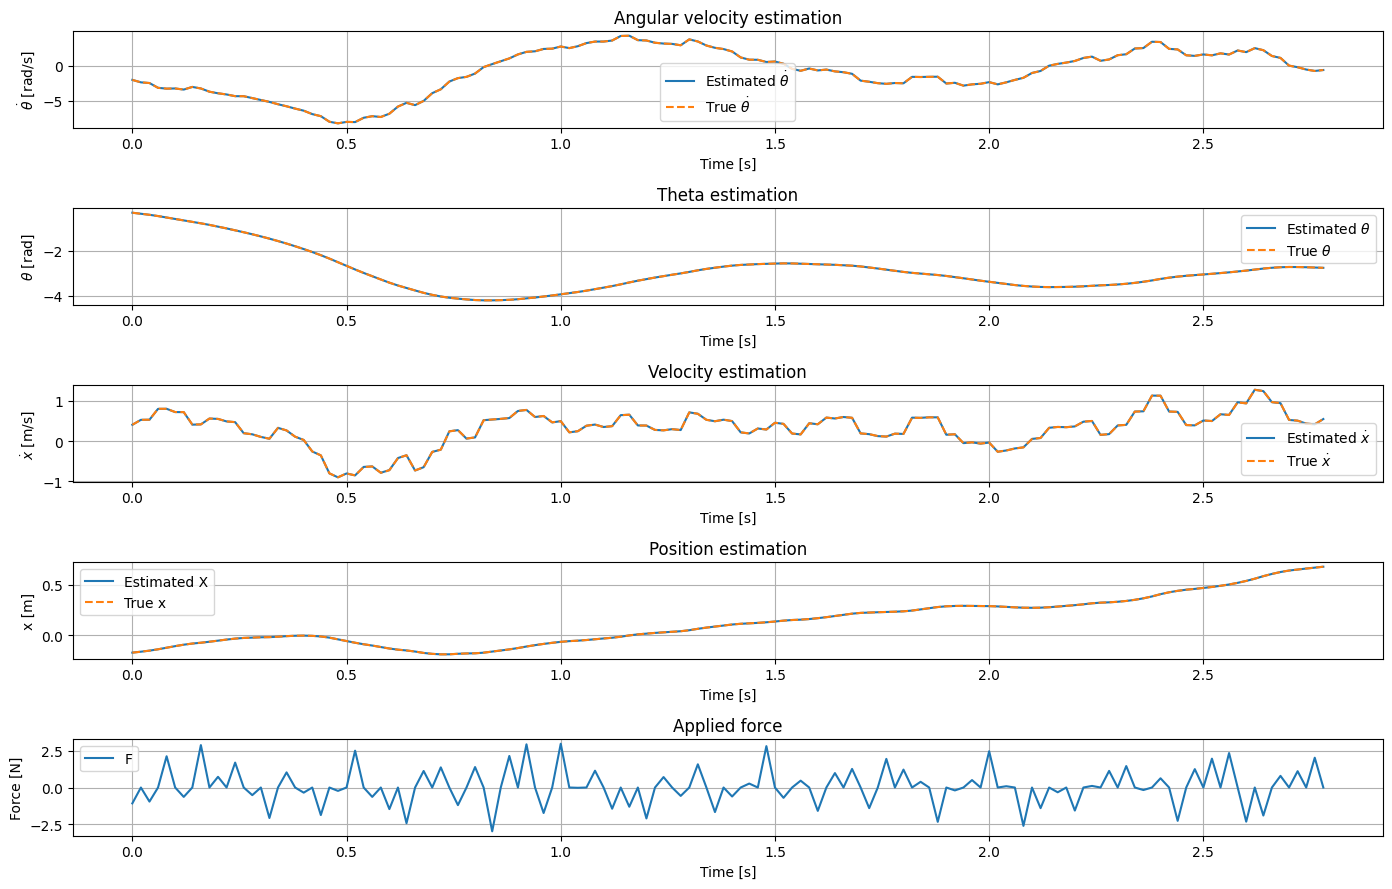

In [7]:
# Noise plot
inverted_pendulum.importPythonModel(name=model_name)
inverted_pendulum.neuralizeModel(sample_time = 0.02)
samples = inverted_pendulum.getSamples(dataset='data_test', window=150-sw, index=0)
result = inverted_pendulum(samples, sampled=True)

#region Plotting
t = np.arange(len(result['est_theta'])) * 0.02
plt.figure(figsize=(14, 9))
plt.subplot(5, 1, 2)
plt.plot(t, result['est_theta'], label=r'Estimated $\theta$')
plt.plot(t, np.array(samples['Yangle']).squeeze(), '--', label=r'True $\theta$')
plt.title('Theta estimation')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.grid()
plt.legend()
plt.subplot(5, 1, 1)
plt.plot(t, result['est_thetadot'], label=r'Estimated $\dot{\theta}$')
plt.plot(t, np.array(samples['Yangular_velocity']).squeeze(), '--', label=r'True $\dot{\theta}$')
plt.title('Angular velocity estimation')
plt.xlabel('Time [s]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.grid()
plt.legend()
plt.subplot(5, 1, 4)
plt.plot(t, result['est_x'], label='Estimated X')
plt.plot(t, np.array(samples['Ypos']).squeeze(), '--', label='True x')
plt.title('Position estimation')
plt.xlabel('Time [s]')
plt.ylabel('x [m]')
plt.grid()
plt.legend()
plt.subplot(5, 1, 3)
plt.plot(t, result['est_xdot'], label=r'Estimated $\dot{x}$')
plt.plot(t, np.array(samples['Yvelocity']).squeeze(), '--', label=r'True $\dot{x}$')
plt.title('Velocity estimation')
plt.xlabel('Time [s]')
plt.ylabel(r'$\dot{x}$ [m/s]')
plt.grid()
plt.legend()
plt.subplot(5, 1, 5)
plt.plot(t, np.array(samples['action']).squeeze()[:,0], label='F')
plt.title('Applied force')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.grid()
plt.legend()
plt.tight_layout()
#endregion

plt.show()

=============================== Load JSON Model ================================
Model loaded from:            /home/baro/Desktop/inv_pend/rk4_models/saved_models/learned_fir_filter_model.json
[neuralizeModel] Closed loop on Xangle with sample in the future.
[neuralizeModel] Closed loop on Xangular_velocity with sample in the future.
[neuralizeModel] Closed loop on Xpos with sample in the future.
[neuralizeModel] Closed loop on Xvelocity with sample in the future.
================================ nnodely Model =================================
{'Constants': {'Constant39': {'dim': 1, 'values': [2.0]},
               'Constant40': {'dim': 1, 'values': [2.0]},
               'Constant41': {'dim': 1, 'values': [2.0]},
               'Constant42': {'dim': 1, 'values': [2.0]},
               'Constant43': {'dim': 1, 'values': [2.0]},
               'Constant44': {'dim': 1, 'values': [2.0]},
               'Constant45': {'dim': 1, 'values': [2.0]},
               'Constant46': {'dim': 1, 'val

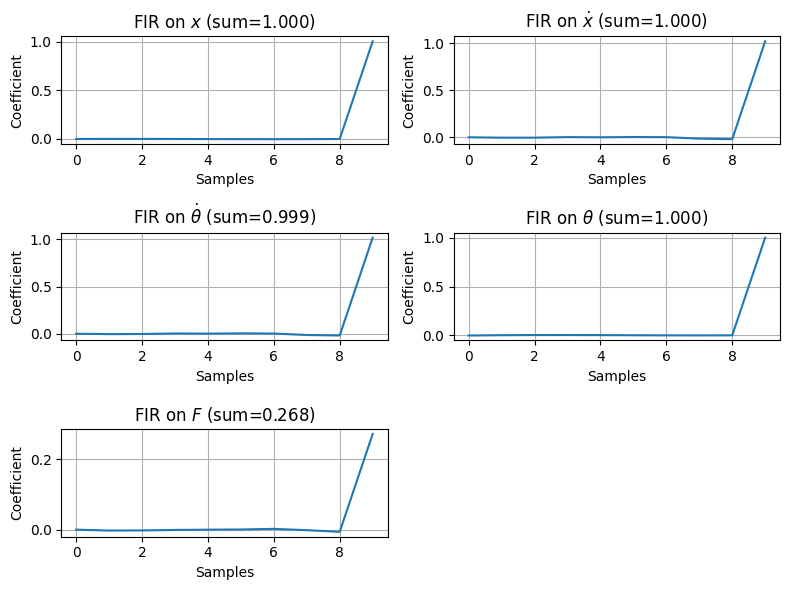

In [8]:
# FIR plots
inverted_pendulum.importPythonModel(name=model_name)
inverted_pendulum.neuralizeModel(sample_time = 0.02)

fir_list = []
for param, name in zip(inverted_pendulum.parameters.values(), inverted_pendulum.parameters.keys()):
    if 'tv' in name:
        fir_list.append(np.array(param['values']).squeeze())

states = [r'$x$', r'$\dot{x}$', r'$\dot{\theta}$', r'$\theta$', r'$F$']
plt.figure(figsize=(8, 6))
for i, fir in enumerate(fir_list):
    plt.subplot(len(fir_list)//2+1, len(fir_list)//2, i+1)
    plt.plot(fir)
    plt.title(f'FIR on {states[i]} (sum={np.sum(fir):.3f})')
    plt.xlabel('Samples')
    plt.ylabel('Coefficient')
    plt.grid()
plt.tight_layout()
img_name = model_name + '_FIRs.png'
save_path = os.path.join(os.getcwd(), "results", "imgs", img_name)
#plt.savefig(save_path, dpi=300)
plt.show()

In [9]:
# Model analysis
inverted_pendulum.analyzeModel('data_test', prediction_samples=50, batch_size=128)

=================== nnodely Model Results for data_test ===================
|     Loss    |        mse        |        FVU        |        AIC        |
|             |    small better   |    small better   |    lower better   |
|-------------------------------------------------------------------------|
|ang_vel_error|     2.332e-04     |     2.067e-05     |     6.938e+05     |
| angle_error |     1.963e-05     |     1.966e-06     |     7.054e+05     |
|  pos_error  |     3.106e-06     |     1.170e-05     |     6.932e+05     |
|  vel_error  |     1.657e-05     |      7.84e-05     |     6.919e+05     |
|-------------------------------------------------------------------------|
|    Total    |     6.812e-05     |     2.818e-05     |     6.961e+05     |
|-------------------------------------------------------------------------|
